---
**Chapter 09**
# **Advanced deep learning for computer vision**
---


In [139]:
# System Libraries
import matplotlib.pyplot as plt
import importlib, sys, os
import numpy as np
import random

# TensorFlow Libraries
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
from tensorflow import keras
import tensorflow as tf

# User Libraries
sys.path.append("../")
from modules import Common, Chapter_01, Chapter_09

# Reload Libraries
importlib.reload(Chapter_01)
importlib.reload(Chapter_09)
importlib.reload(Common)

# Check GPU
print(tf.config.list_physical_devices())

# Module variables
batch_size = 64
epochs = 10

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
- Three essential computer vision tasks
- Image segmentation
- Modern convnet architecture patterns
  - Modularity, hierarchy, reuse
  - Residual connections
  - Batch normalizaton
  - Depthwise separable convolution
  - Mini Xception model
- Interpret what convnets learn
  - Visualize intermediate activations
  - Visualize convet filters
  - Visualize heatmaps of class acitvation
---

- Image classification
  - Assign a class to each pixel of an image
  - Single-label mutliclass classification
  - Multi-label classification
  - Logit layer is Dense
- Image segmentation
  - Semantic segmentation
    - Each pixel is independently classified into a segmentation cateogory
    - If there are two cats in an image, pixels of both will be mapped at **cat**
    - Logit layer is Conv2D
  - Instance segmentation
    - Each pixel is independently classified into a segmentation category
    - Parse out object instances
    - If there are two cats in an image, pixels will be mapped as **cat1** and **cat2**
  - Segmentation mask:
    - Single colour (0-255) label of an image where each integer represents a unique class
    - 1: Background, 2: Bottle 
- Object detection
  - RetinaNet: https://keras.io/examples/vision/retinanet

---
# **Image segmentation**
---


### <ins />**Dataset**

In [ ]:
img_size = (200, 200)
input_raw, input_imgs, labels, num_labels = Chapter_09.dataset(img_size)

**Exploration**

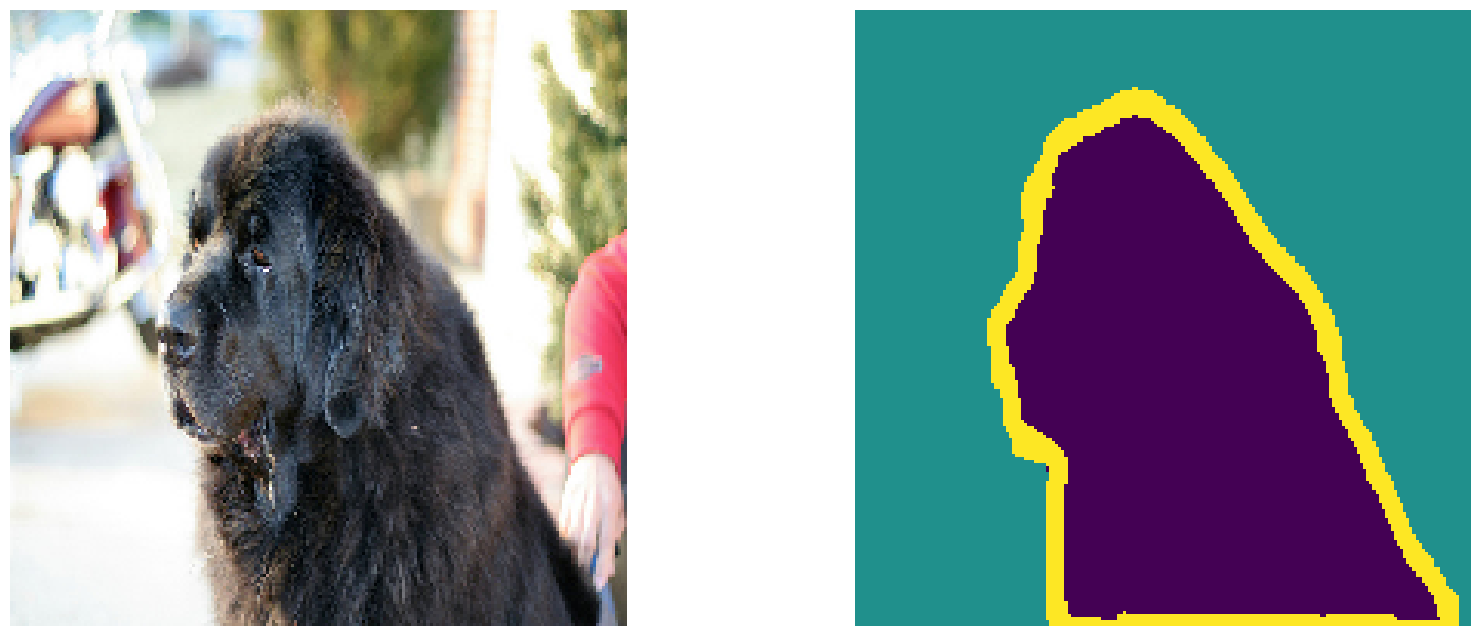

In [144]:
explore_idx = random.randint(0, num_labels)
Chapter_09.explore(input_raw[explore_idx], labels[explore_idx])

### <ins />**Downsample and upsample**

**Downsample:**
- Encode images into smaller feature maps
- Conv2D

**Upsample:**
- To have shape of segmentation mask same as input image
- Conv2DTranspose

**Note:**
- For segmentation and detection, use stride instead of maxpooling

In [ ]:
input_dim = 3
inputs = keras.Input(shape=(120, 120, input_dim))
# Downsample the feature maps
downsample = keras.layers.Conv2D(filters=64, kernel_size=3)(inputs)
# Upsample the feature maps
upsample = keras.layers.Conv2DTranspose(filters=input_dim, kernel_size=3)(downsample)
model = keras.Model(inputs=inputs, outputs=upsample)
model.summary()

### <ins />**Model**

In [ ]:
def get_model(input_size, num_classes):
    # -----------------------------------------
    # Input Layer
    # -----------------------------------------
    inputs = keras.Input(shape=input_size + (3,))
    x = keras.layers.Rescaling(1.0 / 255)(inputs)
    # -----------------------------------------
    # Downsample Layers
    # -----------------------------------------
    x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2)(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
    # -----------------------------------------
    # Upsample Layers
    # -----------------------------------------
    x = keras.layers.Conv2DTranspose(filters=256, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
    x = keras.layers.Conv2DTranspose(filters=256, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2)(x)
    x = keras.layers.Conv2DTranspose(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
    x = keras.layers.Conv2DTranspose(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2)(x)
    x = keras.layers.Conv2DTranspose(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
    x = keras.layers.Conv2DTranspose(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2)(x)
    # -----------------------------------------
    # Output Layer
    # -----------------------------------------
    outputs = keras.layers.Conv2D(filters=num_classes, kernel_size=3, padding="same", activation=tf.nn.softmax)(x)
    # -----------------------------------------
    # Model
    # -----------------------------------------
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

### <ins />**Train**

In [ ]:
model = get_model(img_size=img_size, num_classes=3)
Chapter_01.compile(model=model, metrics=None)
history = Chapter_01.train(input_imgs, labels, model, 0.3, 64, callbacks=Common.callbacks(), epochs=epochs)

### <ins />**Graph**

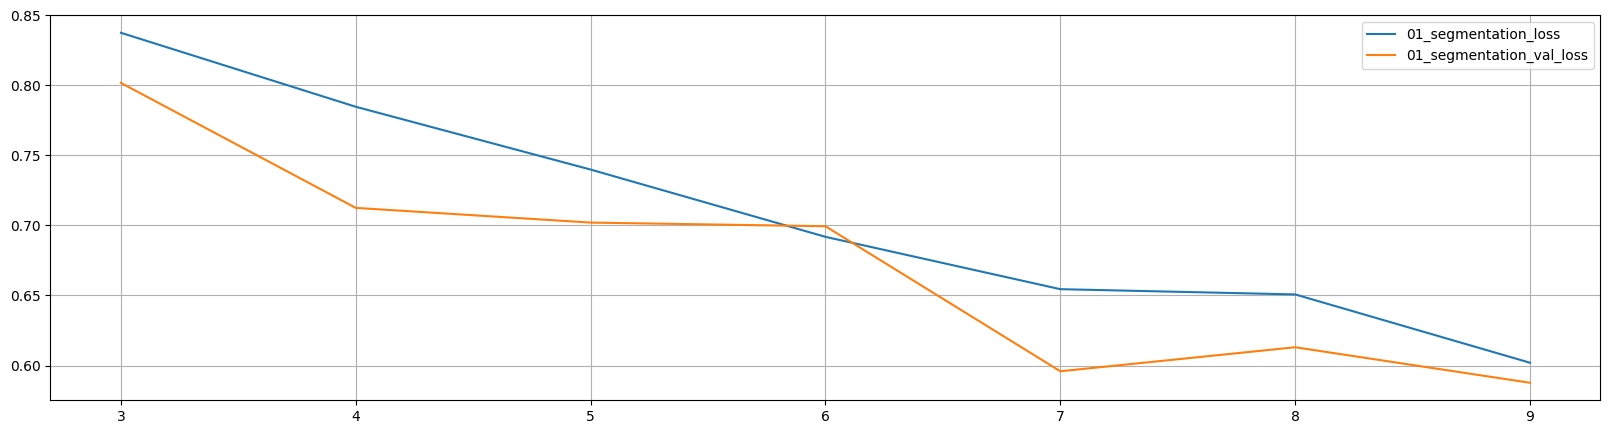

In [149]:
Common.plot_simple(
    data=[history.history["loss"], history.history["val_loss"]],
    labels=["01_segmentation_loss", "01_segmentation_val_loss"],
    start_index=3,
)

### <ins />**Test**

1/1 [==============================] - 0s 16ms/step


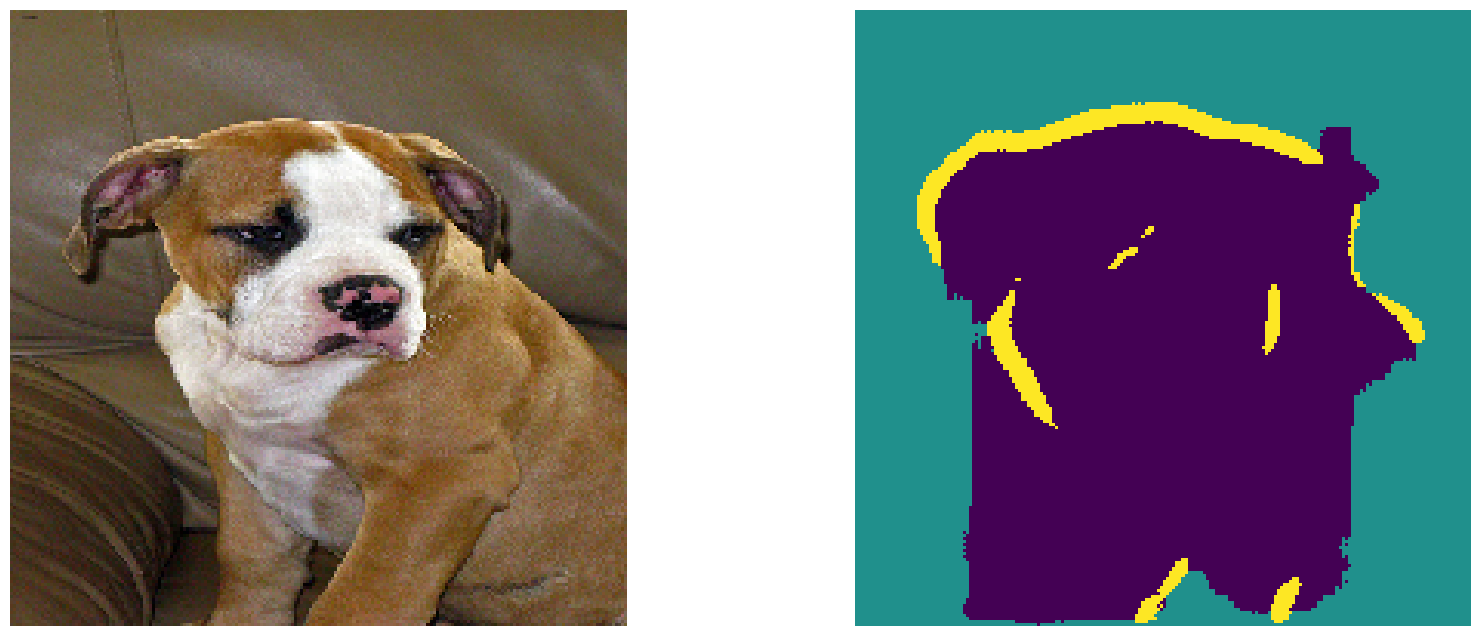

In [148]:
test_idx = random.randint(0, num_labels)
test_img = input_raw[test_idx]
mask = model.predict(np.expand_dims(test_img, 0))[0]
Chapter_09.explore_test(test_img, mask)